## 2D SE exercise: investigation of the excitation pulse profile

Idea of this exercise: measure the slice profile of various RF pulses with Pulseq

### import modules needed for this tutorial

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# newer numpy versions don't contain this, but pypulseq still relies on it
np.int = int; np.float = float; np.complex = complex
# note: current pypulseq developer version 1.4.0 is needed for this tutorial (https://github.com/imr-framework/pypulseq.git)
import pypulseq as pp 

# read Siemens raw data with twixtools https://github.com/pehses/twixtools (twixtools has some advanced features not available in pymapvbvd)
import twixtools



### Definition of helper functions 

|function|purpose|
|:---|:---|
| ```plot_pulse()``` | plots pypulseq rf pulse and its frequency response |
| ```twix_ft()```   | read Siemens raw data and returns its 2D fft (assuming Cartesian acquisition single slice data!) |

In [15]:
#Helper functions

# plot rf pulse and its frequency response (slice profile)
def plot_pulse(rf,fmax=5,osf=1,show_STA=False):
    # input: rf       = pypulseq rf event
    #        fmax     = frequency range for plotting (in kHz, default = 5)
    #        osf      = over sampling factor (integer, default = 1)
    #        show_STA = plot STA in addition to Bloch solution (bool, default = False)

    #a) small tip angle approximation
    FT    = np.abs(np.fft.fftshift(np.fft.fft(rf.signal,len(rf.t)*osf))) # FT of pulse 
    dt    = rf.t[1]-rf.t[0]                                              # sampling time (in sec)
    F     = np.fft.fftshift(np.fft.fftfreq(len(rf.t)*osf,dt))            # frequency axis (in Hz)
    v     = np.real(np.trapz(y=rf.signal,x=rf.t))                        # normalized FA (1=360deg)
    M_STA = dt*(np.sin(2*np.pi*v)/v)*FT[np.abs(F)<1e3*fmax]              # STA solution at ...
    F     = F[np.abs(F)<1e3*fmax]                                        # ... requested frequency range

    #b) hard-pulse solution with spinor calculus 
    #   (see e.g. Pauly et al. 1991. IEEE TMI 10 (1): 53–65. https://doi.org/10.1109/42.75611 )
    M_ROT = np.zeros(len(F))                                             # result vector  
    for i in range(len(F)):
        w = 2*np.pi*F[i]                                                 # angular frequency (in rad/s)
        Q  = np.eye(2,dtype=complex)                                     # init Cayley-Klein matrix
        for j in range(len(rf.signal)):
            s = 2*np.pi*rf.signal[j]                                     # RF pulse signal (in rad/s)
            W = -dt*np.sqrt(np.abs(s)**2+w**2)+np.finfo(float).eps       # effective field rotation angle 
            n = (dt/np.abs(W)) * np.array([s, 0, w])                     # effective field rotation axis
            a = np.cos(W/2)-1j*n[2]*np.sin(W/2)                          # Cayley-Klein parameter alpha             
            b = (-1j*n[0]+n[1])*np.sin(W/2)                              # Cayley-Klein parameter beta 
            Q = np.dot(np.array([[a, -np.conj(b)],[b, np.conj(a)]]),Q )  # chained rotation 
        M_ROT[i] = np.abs(2*np.conj(Q[0,0])*Q[1,0])                      # transverse magnetization 
    
    # plot pulse and frequency response
    plt.figure(figsize=[10,3])
    plt.subplot(121)
    plt.plot(1e3*rf.t,np.real(rf.signal))
    plt.xlabel('time [msec]')
    plt.ylabel('RF [mag Hz]')
    plt.title('FA = %5.2f deg' % (np.abs(v)*360) ) 
    plt.grid()
    plt.subplot(122)
    plt.plot(1e-3*F,M_ROT,label='BE')
    if show_STA:
        plt.plot(1e-3*F,M_STA,'r',label='STA')
        plt.legend(loc='upper right')
    plt.xlabel('frequency [kHz]')
    plt.ylabel('$|M_{xy}|$')
    plt.title('frequency response' )
    plt.grid()
    plt.show()

# read Siemens raw data with twixtools and return image (2d-fft and rsos across coils)
def twix_ft(file):
    twix = twixtools.read_twix(file,verbose=False)
    data = twixtools.map_twix(twix)[-1]                                     # last object is image data
    D=np.fft.fftshift(np.fft.fft2(np.squeeze(data['image'][:]),axes=(0,2))) # coil dim = 1
    D=np.sqrt(np.sum(np.abs(D)**2,axis=1))
    return (D/np.max(D))

### Pypulseq excitation event

- function ```excitation()``` defines the ecitation event

### your tasks
- add more pulses to that function
- pulses available in PyPulseq: Gauss, SLR, SMS (for the last two: see pypulseq function ```sigpy_n_seq```)
- more advanced: implement your own pulse


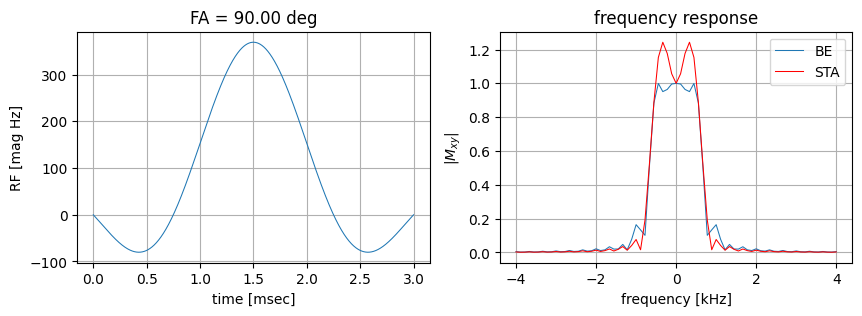

In [24]:
# function definition for the pypulseq excitation events  
def excitation (system, type='sinc',fa_ex=90,slice_thickness=30e-3, rf_dur=3e-3, tbp=3, apodization=0.5):
# input: system           = pulseq scanner limits
#        fa_ex            = excitation flip angle (in degree)
#        slice_thickness  = in meter
#        tbp              = time bandwidth product of RF pulse
#        rf_dur           = pulse duration (in seconds)
#        (add more, if needed)
#
# returns: pypulseq events (rf, gslice, gslice_rewinder)
    
    # sinc pulse
    if type == 'sinc':
            rf1,gz1,gzr1 = pp.make_sinc_pulse(
                flip_angle=fa_ex * np.pi / 180, phase_offset=90 * np.pi / 180, duration=rf_dur,
                slice_thickness=slice_thickness, apodization=apodization, time_bw_product=tbp,
                system=system, return_gz=True)
    # add more pulse shapes using the pypulseq functions for making RF pulses
    # elif type == 'gauss':
    # ... your code
    
    else:
            raise Exception('error in excitation() - unknown pulse type: '+type)
        
    return rf1,gz1,gzr1


#now use the function above to make the excitation events

# scanner limits
sys = pp.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time= 20*10e-6 # use double grad_raster_time to simplify dead time calculations 
)

# RF pulse parameters
excitation_type = 'sinc'   
fa_ex           = 90      # excitation flip angle (in degrees)
slice_thickness = 30e-3   # slice thickness (in meter)
rf_dur          = 3e-3    # excitation  RF pulse duration (in seconds)
tbp             = 4       # time_bw_product
apodization     = 0.0     # sinc apodization factor (0 = no apodization)
n_bands         = 2       # MB factor (only for type 'sms')
band_sep        = 10      # freq. band separation (only for type 'sms')

# excitation pulse events 
rf1, gz1, gzr1 = excitation( sys, type=excitation_type, fa_ex=fa_ex, slice_thickness=slice_thickness, tbp=tbp, apodization=apodization)

#plot pulse shape and frequency response (osf = frequency oversampling factor)
plot_pulse(rf1,fmax=4,osf=3,show_STA=True)

### Implementation of a basic single-slice Spin Echo sequence with pypulseq 
### (using the excitation pulse defined above)

### Your tasks
- Change the sequence to measure the slice profile of the excitation pulse (how?)
- Investigate the slice profile of the sinc-pulse with and without apodization (previous cell)
- Use other excitation pulses and compare the slice profiles with the previous results
- Additionally, investigate the influence of the time-bandwidth-product 
  (a large TPB may require to prolong the RF pulse duration) 

Timing check passed successfully
total sequence duration:  63.99999999999996 sec (check: Ny*TR= 64.0  sec)


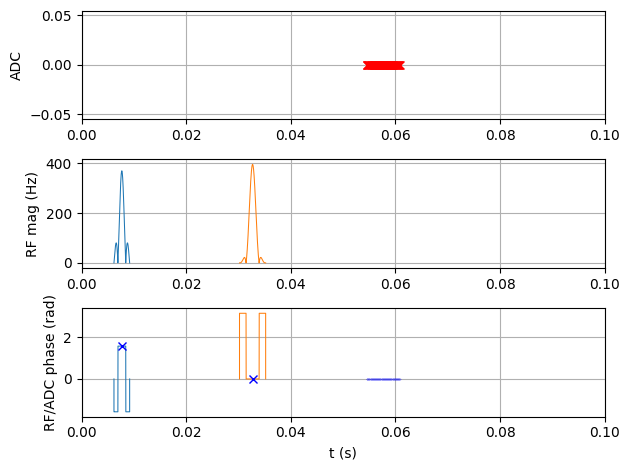

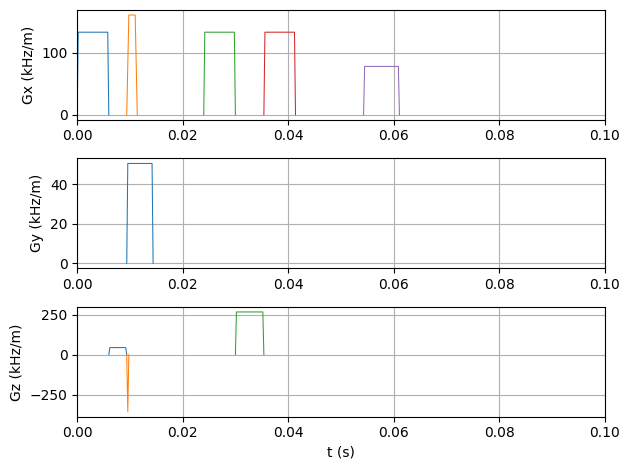

In [25]:
# definition of a basic spin echo sequence using the excitation pulse defined above

experiment_id   = 'se_2D'

# sequence parameters
TE              = 50e-3   # echo time (in seconds)
TR              = 1000e-3 # repetition time (in seconds)
fov             = 128e-3  # [meter]
Nx              = 64      # frequency encoding steps/samples
Ny              = 64      # phase encoding steps/samples
pe_dur          = 5e-3    # phase encode gradient duration
rp_dur          = 2e-3    # read pre-phaser gradient duration
ft_dur          = 6.4e-3  # read gradient flattop duration


# hard-coded refocusing pulse 
rf2, gz2, _ = pp.make_sinc_pulse( flip_angle=np.pi, duration=5e-3, slice_thickness=3e-3, 
                                  apodization=0.5, time_bw_product=4, system=sys, return_gz=True)

# read gradient, read-prephaser, and ADC 
delta_k     = 1 / fov 
gx          = pp.make_trapezoid(channel='x', flat_area=Nx * delta_k  , flat_time=ft_dur, system=sys)
gx_pre      = pp.make_trapezoid(channel='x', area=gx.area / 2, duration=rp_dur, system=sys)
adc         = pp.make_adc(num_samples=Nx, duration=gx.flat_time, delay=gx.rise_time, system=sys)

# spoiler gradient on x (used three times: before excitation, before refocusing, after refocusing) 
gx_sp      = pp.make_trapezoid(channel='x', area=1.5*gx.area, duration=3*rp_dur, system=sys)

                        
# Calculate delays
#TE fill time after de-/ prephasers
te_fill1 = TE/2 - (pp.calc_duration(gz1)/2 + max(pp.calc_duration(gx_pre, gzr1), pe_dur) + pp.calc_duration(gx_sp) + pp.calc_duration(gz2)/2)
#TE fill time after refocusing pulse
te_fill2 = TE/2 - (pp.calc_duration(gz2)/2 + pp.calc_duration(gx_sp) + pp.calc_duration(gx)/2)
#TR fill time after readout
tr_fill  = TR - (pp.calc_duration(gx_sp) + pp.calc_duration(gz1) / 2 + TE + pp.calc_duration(gx) / 2 )

# CONSTRUCT SEQUENCE

seq = pp.Sequence(sys)

for i in range(Ny):  
    seq.add_block(gx_sp)
    seq.add_block(rf1, gz1)
    gy = pp.make_trapezoid(channel='y', area=delta_k*(Ny/2-1-i), duration=pe_dur, system=sys)
    seq.add_block(gx_pre, gy, gzr1)
    seq.add_block(pp.make_delay(te_fill1))
    seq.add_block(gx_sp)
    seq.add_block(rf2, gz2)
    seq.add_block(gx_sp)
    seq.add_block(pp.make_delay(te_fill2))
    seq.add_block(adc, gx)
    seq.add_block(pp.make_delay(tr_fill))

# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]

# print total duration and plot sequence
d,_,_ =seq.duration()
print('total sequence duration: ',d,'sec (check: Ny*TR=',Ny*TR,' sec)')
seq.plot(time_range=(0,2*TE))

seq.set_definition('FOV', [fov, fov, slice_thickness])
seq.set_definition('Name', 'se')
seq.write(experiment_id + '_' + excitation_type + '.seq')



### Results
- the pulseq file ```se_2D_sinc.seq``` was executed at the scanner
- raw data: ```../data/meas_MID00243_FID33257_pulseq.dat```
- the resulting image is plotted below.

### Your tasks
- execute your pulseq experiments on the scanner
- read raw data files and plot images (slice profiles!) accordingly

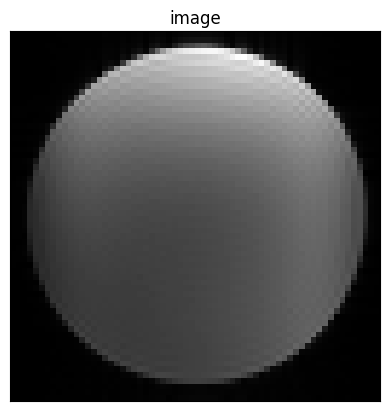

In [26]:
# plot 2D FFT of raw data 
D = twix_ft(file='../data/meas_MID00243_FID33257_pulseq.dat')  
plt.imshow(D,cmap='gray') 
plt.title('image')
plt.xticks([])
plt.yticks([])
plt.show()